In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

In [2]:
ticker = 'PETR4'
dataset_se = pd.read_csv(f'./dataset/{ticker}.csv', index_col='date', parse_dates=True)

In [3]:
dataset_se.head()

,val_high,val_open,val_low,val_close,val_close_final,volume,Moving average 7,Moving average 30,Momentum 7
date,,,,,,,,,
2006-05-12,23.60,23.33,23.25,23.68,16.69,651535232,23.680000,23.680000,1.09
2006-05-15,23.50,23.25,22.40,23.45,16.53,1336049152,23.647143,23.672333,0.58
2006-05-16,23.30,23.12,22.60,22.85,16.10,671452672,23.528571,23.644667,-0.17
2006-05-17,23.08,22.73,22.00,23.00,16.21,601421120,23.431429,23.622000,0.59
2006-05-18,22.50,22.50,21.66,21.75,15.32,17677400,23.155714,23.557667,-0.62


In [4]:
# Check if has any value in the features is not applicable
dataset_se.isna().any()

val_high             False
val_open             False
val_low              False
val_close            False
val_close_final      False
volume               False
Moving average 7     False
Moving average 30    False
Momentum 7           False
dtype: bool

In [5]:
dataset_se.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3691 entries, 2006-05-12 to 2021-04-01
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   val_high           3691 non-null   float64
 1   val_open           3691 non-null   float64
 2   val_low            3691 non-null   float64
 3   val_close          3691 non-null   float64
 4   val_close_final    3691 non-null   float64
 5   volume             3691 non-null   int64  
 6   Moving average 7   3691 non-null   float64
 7   Moving average 30  3691 non-null   float64
 8   Momentum 7         3691 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 288.4 KB


<AxesSubplot:xlabel='date'>

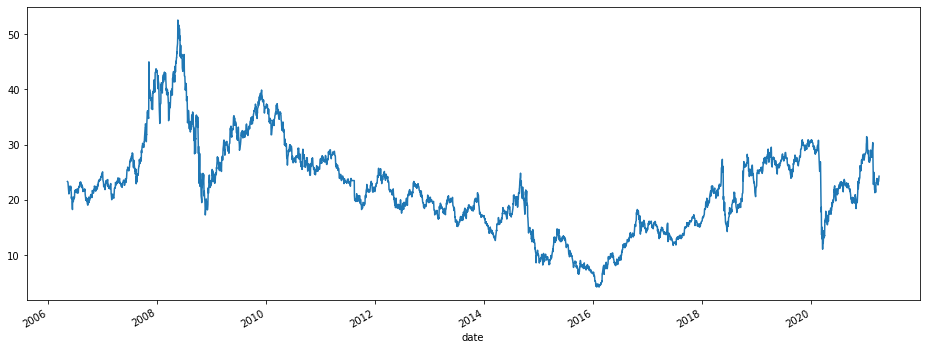

In [6]:
dataset_se['val_open'].plot(figsize=(16,6))

<AxesSubplot:xlabel='date'>

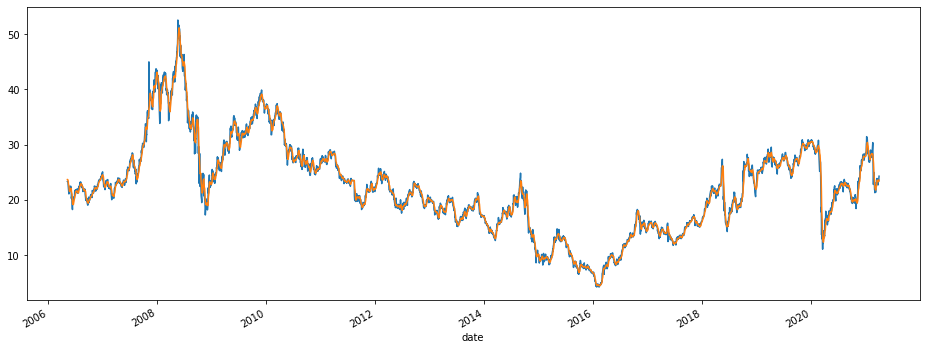

In [7]:
# Moving average of 7 days
dataset_se['val_open'].plot(figsize=(16,6))
dataset_se['Moving average 7'].plot()

<AxesSubplot:xlabel='date'>

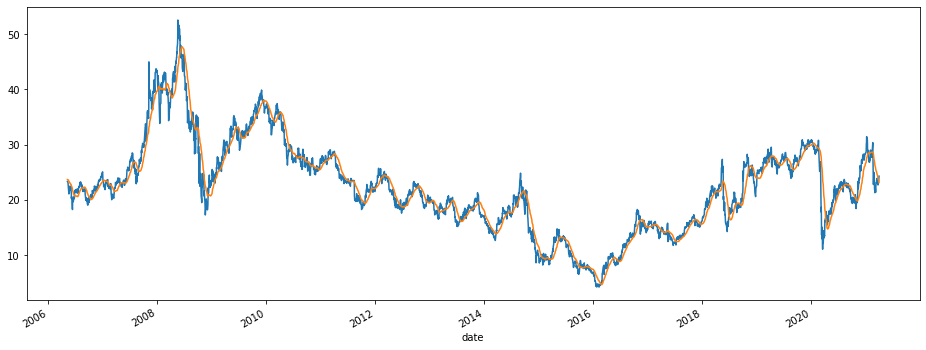

In [8]:
# Moving average of 30 days
dataset_se['val_open'].plot(figsize=(16,6))
dataset_se['Moving average 30'].plot()

## Decisions

In [9]:
def profit(df_buying_and_selling):
    return
    
def buying_and_selling_moving_average(dataset, col_stock_price, col_average_7, col_average_30):
    _buying_selling_rate = 0.2 # Taxa de compra/venda em momentos de decisão
    _decision_threshold = 0.05 # Teto/limiar de decisão
    _op_buying = 'buy'
    _op_selling = 'sel'

    stock_units = 1000 # Quantitade de ativos inicial
    prices = []
    operations = []
    units = []
    
    for index, row in dataset.iterrows():
        decision_evaluation = row[col_average_7] / row[col_average_30]
        #print(f'AV7: {row[col_average_7]},\nAV30: {row[col_average_30]},\nDE: {decision_evaluation}\n\n')

        if (decision_evaluation>1 and (decision_evaluation-1) > _decision_threshold): # (média 7 dias % < média 30) → compro
            buying_units = round(_buying_selling_rate*stock_units)

            operations.append(_op_buying)
            prices.append(row[col_stock_price])
            units.append(buying_units)

            stock_units = stock_units + buying_units

        if (decision_evaluation<1 and (-decision_evaluation+1) > _decision_threshold): #  (média 7 dias % > média 30) → vendo
            selling_units = round(_buying_selling_rate*stock_units)

            operations.append(_op_selling)
            prices.append(row[col_stock_price])
            units.append(selling_units)

            stock_units = stock_units + selling_units

    df_buying_and_selling = pd.DataFrame({'price': prices,
                                          'operation': operations,
                                          'units': units})
    
    return df_buying_and_selling


df = buying_and_selling_moving_average(dataset_se, 'val_open', 'Moving average 7', 'Moving average 30')


# Buying and Selling without NN

# Buying and Selling w/ NN

## Split Train Test

In [10]:
from pre_process_data import DataModeling

In [11]:
rules = {
    "global": ["norm"],
    "data-set-proportion": {
        "train": 0.8,
        "train-validation": 0.15,
    }
}

In [12]:
features_cols = ['val_high','volume','Moving average 7','Moving average 30', 'Momentum 7']
target_col ='val_close'

data_modeling = DataModeling(dataset_se, features_cols, target_col, rules, input_width=30, label_width=30, shift=7)

## Visualization

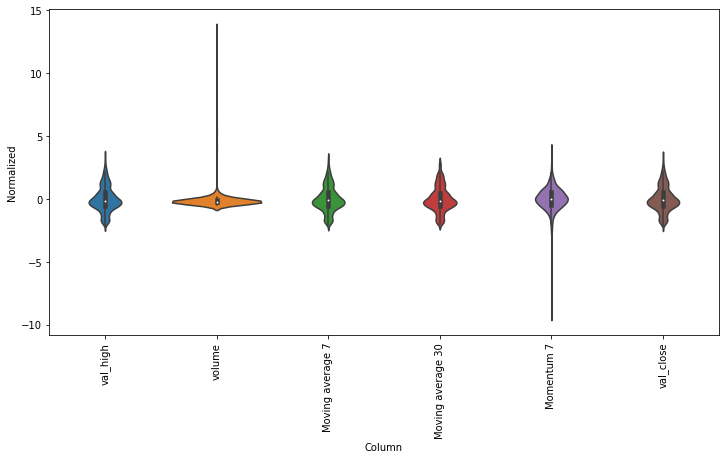

In [13]:
import seaborn as sns

data_to_plot = data_modeling.window_data.train_scaled

df_std = data_to_plot.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(data_to_plot.keys(), rotation=90)

## Working with WindowGenerator

In [14]:
from lstm import LSTMModel

wide_window = data_modeling.window

model = LSTMModel()

In [15]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', model.regressor(wide_window.example[0]).shape)

Input shape: (32, 30, 6)
Output shape: (32, 30, 1)


In [16]:
val_performance = {}
performance = {}

history = model.compile_and_fit(wide_window)

Epoch 1/200
74/74 [==============================] - 20s 110ms/step - loss: 0.4977 - mean_absolute_error: 0.4925 - val_loss: 0.1954 - val_mean_absolute_error: 0.2936
Epoch 2/200
74/74 [==============================] - 3s 39ms/step - loss: 0.1591 - mean_absolute_error: 0.2692 - val_loss: 0.1479 - val_mean_absolute_error: 0.2603
Epoch 3/200
74/74 [==============================] - 3s 41ms/step - loss: 0.1202 - mean_absolute_error: 0.2333 - val_loss: 0.1101 - val_mean_absolute_error: 0.2118
Epoch 4/200
74/74 [==============================] - 3s 46ms/step - loss: 0.0970 - mean_absolute_error: 0.2115 - val_loss: 0.0856 - val_mean_absolute_error: 0.1803
Epoch 5/200
74/74 [==============================] - 3s 41ms/step - loss: 0.0861 - mean_absolute_error: 0.2007 - val_loss: 0.0718 - val_mean_absolute_error: 0.1706
Epoch 6/200
74/74 [==============================] - 3s 43ms/step - loss: 0.0743 - mean_absolute_error: 0.1901 - val_loss: 0.0625 - val_mean_absolute_error: 0.1667
Epoch 7/200
74

## Plotting model predict and eval performance

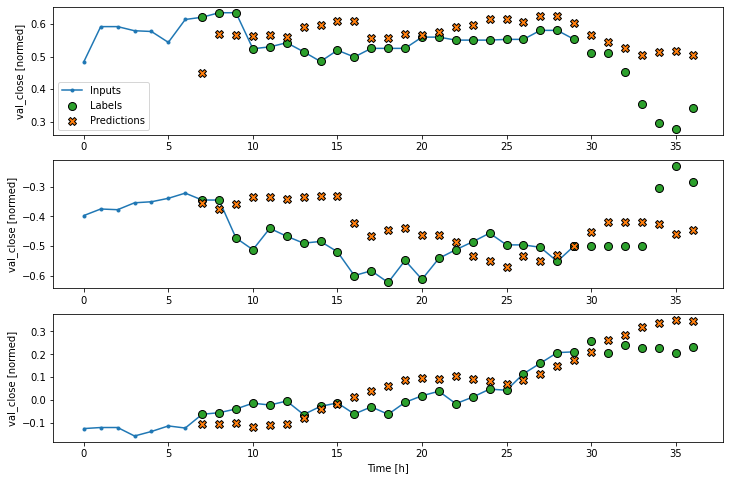

In [17]:
wide_window.plot(plot_col=target_col, model=model.regressor)

In [18]:
val_performance['LSTM'] = model.regressor.evaluate(wide_window.val, verbose=0)
performance['LSTM'] = model.regressor.evaluate(wide_window.test)

22/22 [==============================] - 0s 10ms/step - loss: 0.0975 - mean_absolute_error: 0.2282


## Estimating profit

In [19]:
import math

def is_approximate_values(f_value, s_value):
    return math.isclose(f_value, s_value, rel_tol=1e-6)

In [20]:
def get_equivalent_data(df, values):
    values_length = len(values)
    for index, row in df.iterrows():
        if is_approximate_values(row[target_col], values[0]):
            if all_next_elements_equals(df[index:], values):
                return df[index:].iloc[0:values_length+7]
                
    return None


In [21]:
def all_next_elements_equals(df, values):
    i = 0
    for index, row in df.iterrows():
        if i == len(values):
            return True

        if not is_approximate_values(row[target_col], values[i]):
            return False
        i += 1
    return False

In [22]:
def test_plot(plot_col, data_modeling, inverse_process_func, intervals_to_analysis=4, model=None):
        dfs_positional = []

        inputs, labels = next(iter(wide_window.test))

        inputs_unscaleds = inverse_process_func(data_modeling.window_data.train_stats, inputs)
        labels_unscaleds = inverse_process_func(data_modeling.window_data.train_stats, labels)

        plt.figure(figsize=(12, 8))

        plot_col_index = wide_window.column_indices[plot_col]
        max_n = min(intervals_to_analysis, len(inputs))

        for n in range(max_n):
            df_equivalent = get_equivalent_data(wide_window.test_df, inputs[n, :, plot_col_index])[[plot_col]]

            input_indices = list(df_equivalent.index)[:len(list(df_equivalent.index))-wide_window.shift]
            label_indices = list(df_equivalent.index)[wide_window.shift:]
            
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(input_indices, inputs_unscaleds[n, :, plot_col_index],
                    label='Inputs', marker='.', zorder=-10)

            if wide_window.label_columns:
                label_col_index = wide_window.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue
            
            plt.scatter(label_indices, labels_unscaleds[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)


            if model is not None:
                predictions = model(inputs)

                predictions_unscaleds = inverse_process_func(data_modeling.window_data.train_stats, predictions)
                df_equivalent[plot_col] = np.concatenate((np.zeros(7), np.array(labels_unscaleds[n, :, label_col_index])), axis=0)
                dfs_positional.append(df_equivalent)

                dfs_positional[n]["predicted"] = np.concatenate((np.zeros(7), np.array(predictions_unscaleds[n, :, label_col_index])), axis=0)

                plt.scatter(label_indices, predictions_unscaleds[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [d]')
        return dfs_positional

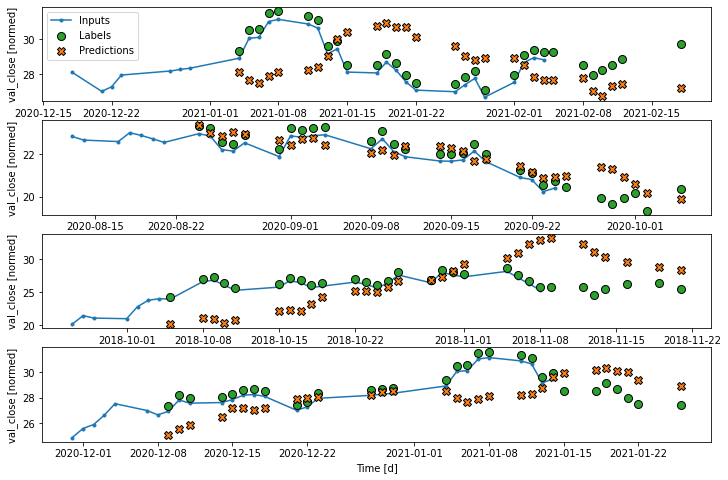

In [23]:
dfs_positional = test_plot(target_col, data_modeling, DataModeling.inverse_norm, model=model.regressor)

In [24]:
SIGNAL_COLUMN = "signal"
NEUTRAL_SIGNAL = "neutral"
BUY_SIGNAL = "buy"
SELL_SIGNAL = "sell"

def analyze_interval(df, index, shift, ignore_first_numbers=3, column_predicted="predicted", difference_percentage=0.05):
    should_ignore = True
    
    df[SIGNAL_COLUMN] = NEUTRAL_SIGNAL
    
    indexes_to_buy = set()
    indexes_to_sell = set()

    for index, row in df.iterrows():
        if row[column_predicted] != 0:
            if not should_ignore:
                current_indexes_to_buy, current_indexes_to_sell = create_signals_index(df[index:].iloc[:shift], column_predicted, difference_percentage, SIGNAL_COLUMN)
                indexes_to_buy = indexes_to_buy.union(set(current_indexes_to_buy))
                indexes_to_sell = indexes_to_sell.union(set(current_indexes_to_sell))
            else:
                ignore_first_numbers -= 1
                if ignore_first_numbers == 0:
                    should_ignore = False
    # print(indexes_to_sell)
    print(f"Number of operations\nBuy: {len(indexes_to_buy)}\nSell: {len(indexes_to_sell)}")
    df.loc[df.index.isin(indexes_to_buy), SIGNAL_COLUMN] = BUY_SIGNAL
    df.loc[df.index.isin(indexes_to_sell), SIGNAL_COLUMN] = SELL_SIGNAL

In [25]:
for df_positional in dfs_positional:
    df_positional["value_to_operate"] = dataset_se.loc[df_positional.index][target_col]

dfs_positional[1].head()

,val_close,predicted,value_to_operate
date,,,
2020-08-13,0.0,0.0,22.84
2020-08-14,0.0,0.0,22.67
2020-08-17,0.0,0.0,22.60
2020-08-18,0.0,0.0,23.02
2020-08-19,0.0,0.0,22.89


In [26]:
def create_signals_index(df, column_predicted, difference_percentage, SIGNAL_COLUMN):
    
    indexes_to_buy = []
    indexes_to_sell = []

    for current_index, current in df.iterrows():
        for future_index, future in df.loc[current_index:].iloc[1:].iterrows():
            if is_signal_to_buy(current[column_predicted], future[column_predicted], difference_percentage):
                # print(f"Buy on date {current_index}(R${current[column_predicted]}) because future date {future_index}(R${future[column_predicted]})")
                indexes_to_buy.append(current_index)
            else:
                if is_signal_to_sell(current[column_predicted], future[column_predicted], difference_percentage):
                    # print(f"Sell on date {current_index}(R${current[column_predicted]}) because future date {future_index}(R${future[column_predicted]})")
                    indexes_to_sell.append(current_index)

    return indexes_to_buy, indexes_to_sell
    
def is_signal_to_buy(current_value, future_value, difference_percentage):
    return (1 - current_value/future_value) >= difference_percentage

def is_signal_to_sell(current_value, future_value, difference_percentage):
    return (current_value/future_value - 1) >= difference_percentage

In [27]:
analyze_interval(dfs_positional[0], SIGNAL_COLUMN, wide_window.shift)

Number of operations
Buy: 5
Sell: 9


In [28]:
COLUMN_TO_OPERATE = "value_to_operate"

def create_positions(df, initial_capital=10000, percentage_to_operate=0.05):
    position = {}
    current_capital = initial_capital
    for index, row in df.iterrows():
        capital_to_operate = current_capital*percentage_to_operate
        if row[SIGNAL_COLUMN] == BUY_SIGNAL and capital_to_operate > row[COLUMN_TO_OPERATE]:
            # print(f"capital_to_operate: {capital_to_operate}\nprice: {row[COLUMN_TO_OPERATE]}")
            
            amount = math.floor(capital_to_operate/row[COLUMN_TO_OPERATE])
            total = row[COLUMN_TO_OPERATE]*amount
            position[index] = {
                "type": BUY_SIGNAL,
                "amount": amount,
                "price": total
            }

            current_capital -= total
        if row[SIGNAL_COLUMN] == SELL_SIGNAL and has_open_position(position):
            amount = min(math.floor(get_amount_open_position(position) * percentage_to_operate), get_open_position(position))
            total = row[COLUMN_TO_OPERATE]*amount
            # print(f"selling {amount} with avg_price {avg_price}")

            position[index] = {
                "type": SELL_SIGNAL,
                "amount": amount,
                "price": total
            }

            current_capital += total

    return position


In [29]:
def get_open_position(position):
    amount = 0
    
    for key in position.keys():
        if position[key].get("type") == BUY_SIGNAL:
            amount += position[key].get("amount")
        
        if position[key].get("type") == SELL_SIGNAL:
            amount -= position[key].get("amount")
    return amount

In [30]:
def has_open_position(position):
    return get_open_position(position) > 0

In [31]:
def get_amount_open_position(position):
    amount = 0
    for key in position.keys():
        if position[key].get("type") == BUY_SIGNAL:
            amount += position[key].get("amount")
    return amount

In [32]:
initial_capital=10000

position = create_positions(dfs_positional[0], initial_capital=initial_capital, percentage_to_operate=0.05)

In [33]:
def get_total_price(position, type):
    total = 0
    amount = 0
    for key in position.keys():
        if position[key].get("type") == type:
            total += position[key].get("price")
            amount += position[key].get("amount")
    return total, amount

In [34]:
def get_profit(position):
    total_buy_price, amount_buy = get_total_price(position, BUY_SIGNAL)
    total_sell_price, amount_sell = get_total_price(position, SELL_SIGNAL)

    profit = total_sell_price - total_buy_price
    avg_buy_price = total_buy_price/amount_buy if amount_buy > 0 else 0
    avg_sell_price = total_sell_price/amount_sell if amount_sell > 0 else 0

    return profit, avg_buy_price, avg_sell_price

In [35]:
get_total_price(position, BUY_SIGNAL)

(2231.7599999999998, 73)

In [36]:
get_total_price(position, SELL_SIGNAL)

(750.6, 27)

In [37]:
profit, avg_buy_price, avg_sell_price = get_profit(position)
print(f"Profit: {profit}\nAvgBuyPrice: {avg_buy_price}\nAvgSellPrice:{avg_sell_price}\n\n")

Profit: -1481.1599999999999
AvgBuyPrice: 30.572054794520543
AvgSellPrice:27.8




In [38]:
def concat_positions(first_position, second_position):
    for key in second_position.keys():
        first_position[key] = second_position[key]

In [39]:
profit = 0
initial_capital=10000
position = {}

for df in dfs_positional:
    analyze_interval(df, SIGNAL_COLUMN, wide_window.shift)
    current_position = create_positions(df, initial_capital=initial_capital, percentage_to_operate=0.05)

    concat_positions(position, current_position)

    current_profit, current_avg_buy_price, current_avg_sell_price = get_profit(position)
    profit += current_profit
    

price_buy, amount_buy = get_total_price(position, BUY_SIGNAL)
price_sell, amount_sell = get_total_price(position, SELL_SIGNAL)

avg_buy_price = price_buy/amount_buy
avg_sell_price = price_sell/amount_sell


Number of operations
Buy: 5
Sell: 9
Number of operations
Buy: 0
Sell: 7
Number of operations
Buy: 18
Sell: 6
Number of operations
Buy: 7
Sell: 0


In [40]:
profit, avg_buy_price, avg_sell_price

(-15045.46, 27.49609375, 26.023440860215054)